To run the code, please setup the anaconda environment by running the following code.
```bash
conda env create -f env-gpu.yaml
conda activate ML
```

In [1]:
import numpy as np
import json_lines

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/henorvell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henorvell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
X = []; y_voted_up=[]; y_early_access=[]
with open('data/reviews_112_trans-en.jl', 'rb') as reader:
    for line in json_lines.reader(reader):
        X.append(line['trans_en'])
        y_voted_up.append(line['voted_up'])
        y_early_access.append(line['early_access'])

In [4]:
y_voted_up = np.array(y_voted_up).astype(int)
y_early_access = np.array(y_early_access).astype(int)

In [5]:
vectorizer = TfidfVectorizer(
    stop_words = nltk.corpus.stopwords.words('english'),
    max_df=0.2)

In [6]:
X_vec = vectorizer.fit_transform(X)

In [7]:
train, test = train_test_split(np.arange(len(X)), test_size=0.1)

In [8]:
def print_confusion_matrix(preds, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true[test], preds).ravel()

    print('Confusion matrix:')
    print('[{}, {}]'.format(tp, fp))
    print('[{}, {}]'.format(fn, tn))

In [9]:
import matplotlib.pyplot as plt
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    try:
        auc = roc_auc_score(y, pred)
    except ValueError:
        auc = "undefined"

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}")

# kNN voted up

In [10]:
# tuned_parameters = {
#     "n_neighbors": [2, 3]
# }
model = KNeighborsClassifier(n_neighbors=3, metric=cosine_distances)
model.fit(X_vec[train], y_voted_up[train])
# clf = GridSearchCV(model, tuned_parameters, cv=5, refit=False, scoring='accuracy', n_jobs=4, verbose=10)
# clf.fit(X_vec[train], y_voted_up[train])
# print(clf.best_estimator_.get_params())

KNeighborsClassifier(metric=<function cosine_distances at 0x7feed658a4d0>,
                     n_neighbors=3)

In [11]:
preds_proba = model.predict_proba(X_vec[test])
preds = preds_proba.argmax(axis=-1)
print_confusion_matrix(preds, y_voted_up)
print('Accuracy: %.4f' % accuracy_score(y_voted_up[test], preds))

Confusion matrix:
[175, 96]
[66, 163]
Accuracy: 0.6760


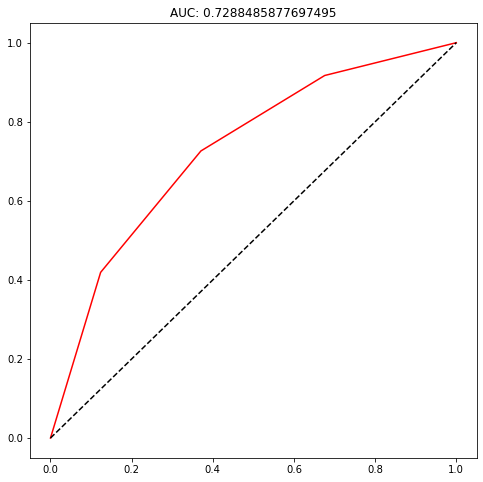

In [12]:
plot_roc(preds_proba[:, 1], y_voted_up[test])

# kNN early access

In [13]:
model = KNeighborsClassifier(n_neighbors=3, metric=cosine_distances)
model.fit(X_vec[train], y_early_access[train])

KNeighborsClassifier(metric=<function cosine_distances at 0x7feed658a4d0>,
                     n_neighbors=3)

In [14]:
preds_proba = model.predict_proba(X_vec[test])
preds = preds_proba.argmax(axis=-1)
print_confusion_matrix(preds, y_early_access)
print('Accuracy: %.4f' % accuracy_score(y_early_access[test], preds))

Confusion matrix:
[2, 21]
[51, 426]
Accuracy: 0.8560


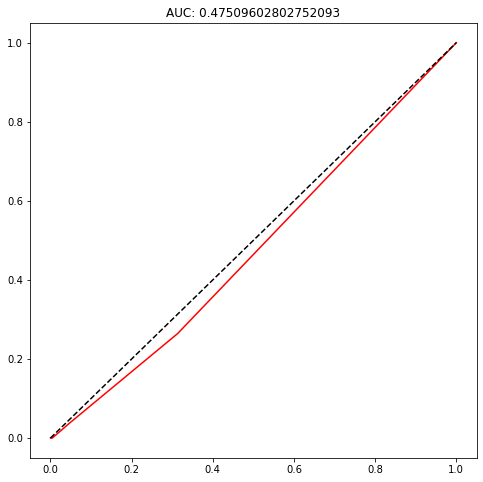

In [15]:
plot_roc(preds_proba[:, 1], y_early_access[test])

# Kernelised kNN voted up

In [16]:
def gaussian_kernel_builder(gamma):
    def gaussian_kernel(distances):
        weights = np.exp(-1*gamma*(distances**2))
        return weights/np.sum(weights)
    return gaussian_kernel

In [17]:
model = KNeighborsClassifier(n_neighbors=3, 
    metric=cosine_distances, weights=gaussian_kernel_builder(15))
model.fit(X_vec[train], y_voted_up[train])

KNeighborsClassifier(metric=<function cosine_distances at 0x7feed658a4d0>,
                     n_neighbors=3,
                     weights=<function gaussian_kernel_builder.<locals>.gaussian_kernel at 0x7feedafb8200>)

In [18]:
preds_proba = model.predict_proba(X_vec[test])
preds = preds_proba.argmax(axis=-1)
print_confusion_matrix(preds, y_voted_up)
print('Accuracy: %.4f' % accuracy_score(y_voted_up[test], preds))

Confusion matrix:
[175, 99]
[66, 160]
Accuracy: 0.6700


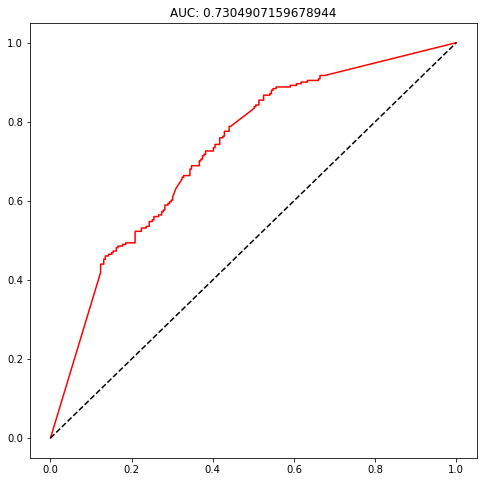

In [19]:
plot_roc(preds_proba[:, 1], y_voted_up[test])

# Kernelised kNN early access

In [20]:
model = KNeighborsClassifier(n_neighbors=3, 
    metric=cosine_distances, weights=gaussian_kernel_builder(15))
model.fit(X_vec[train], y_early_access[train])

KNeighborsClassifier(metric=<function cosine_distances at 0x7feed658a4d0>,
                     n_neighbors=3,
                     weights=<function gaussian_kernel_builder.<locals>.gaussian_kernel at 0x7feedac31710>)

In [21]:
preds_proba = model.predict_proba(X_vec[test])
preds = preds_proba.argmax(axis=-1)
print_confusion_matrix(preds, y_early_access)
print('Accuracy: %.4f' % accuracy_score(y_early_access[test], preds))

Confusion matrix:
[3, 28]
[50, 419]
Accuracy: 0.8440


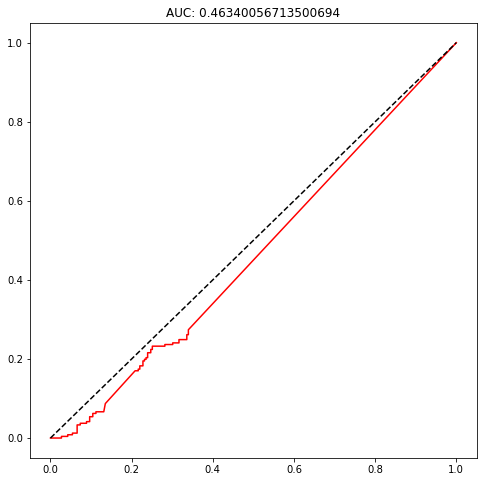

In [22]:
plot_roc(preds_proba[:, 1], y_voted_up[test])